理论收敛率 μ = 0.8086


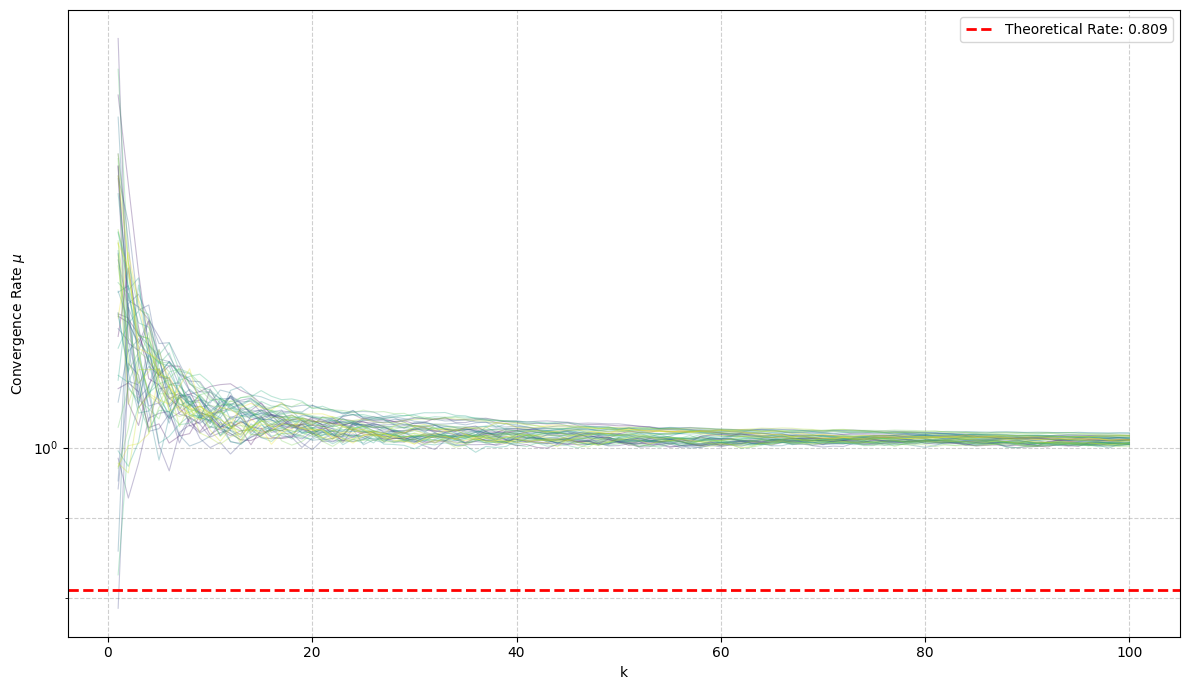

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from scipy.linalg import eigh

# params
n = 50
s = 0.9                                 # 最优参数
q = 0.2                                 # 更慢的噪声衰减
delta = 1.0
epsilon = 0.1
c = delta * q / (epsilon * (q - abs(s - 1)))
p = 0.1
threshold = 1e-2

# 构建邻接矩阵
A = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        if (np.random.binomial(1, p) + np.random.binomial(1, p)):
            A[i, j] = 1
            A[j, i] = 1

# 多初始条件实验
num_initial_conditions = 50             # 初始条件数量
num_runs_per_initial = 50               # 每个初始条件的运行次数
max_iter = 100                          # 增加迭代次数

D = np.diag(A.sum(axis=1))              # 节点度矩阵
L = D - A                               # 邻接矩阵的拉普拉斯矩阵
d_max = D.max().item()                  # 节点度最大值
h = 0.99 / d_max                        # h参数

# 计算理论收敛率
I = np.eye(n)
Pi_n = np.ones((n, n)) / n
M = I - h*L - Pi_n
eigenvalues = np.linalg.eigvals(M)
lambda_bar = np.max(np.abs(eigenvalues))
print(f"理论收敛率 μ = {lambda_bar:.4f}")

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 1, num_initial_conditions))

# 单次模拟
def simulation_single(theta0, c, A, B, q, iters):
    theta = theta0.copy()
    q_powered = 1
    for _ in range(iters):
        b = c * q_powered
        eta = np.random.laplace(scale=b, size=n)
        next_theta = A @ theta + B @ eta

        theta = next_theta
        q_powered *= q

    return theta

for cond_idx in range(num_initial_conditions):
    theta0 = np.random.normal(50, 10, n)
    convergence_rates = []
    A = np.eye(n) - h * L
    B = s * np.eye(n) - h * L

    theta = theta0.copy()
    theta_infty = simulation_single(theta0, c, A, B, q, max_iter)

    for k in range(1, max_iter+1):
        theta = simulation_single(theta, c, A, B, q, 1)
        mu = (np.mean((theta - theta_infty).T @ (theta - theta_infty)) / np.mean((theta0 - theta_infty).T @ (theta0 - theta_infty))) ** (1 / (2 * k))
        convergence_rates.append(mu)
        
    
    # 绘制单条曲线（带透明度）
    plt.semilogy(
        range(1, max_iter+1), 
        convergence_rates,
        color=colors[cond_idx],
        alpha=0.3,
        linewidth=0.8
    )

# 绘制理论参考线和上确界包络线
plt.axhline(
    lambda_bar, 
    color='red', 
    linestyle='--',
    linewidth=2,
    label=f'Theoretical Rate: {lambda_bar:.3f}'
)

# 添加图例和标签
plt.xlabel("k")
plt.ylabel("Convergence Rate $\\mu$")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
# plt.ylim(top=1.0, bottom=1e-3)  # 调整坐标范围

plt.tight_layout()
plt.show()